**временные ряды и модели ARIMA**

Евгений Борисов <esborisov@sevsu.ru>

-----

Дмитрий Макаров   Временные ряды.    
https://www.dmitrymakarov.ru/intro/time-series-20/

Евгений Рябенко Прогнозирование временных рядов.     
https://www.youtube.com/watch?v=u433nrxdf5k

-----

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%precision 3
np.set_printoptions(precision=2)
np.set_printoptions(linewidth=110)
# np.get_printoptions()

# загружаем данные

AirPassengers.csv

https://drive.google.com/file/d/1yfw6gcgmJXCtxkjC69ekUvsEtAiYTlST/view?usp=share_link

https://huggingface.co/spaces/Anniek/Time_series_forecast/raw/main/AirPassengers.csv

In [3]:
# читаем данные
url = 'https://huggingface.co/spaces/Anniek/Time_series_forecast/raw/main/AirPassengers.csv'
df = pd.read_csv(url).convert_dtypes()
display(df.info())
display(df.describe().T)
display(df.sample(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    string
 1   #Passengers  144 non-null    Int64 
dtypes: Int64(1), string(1)
memory usage: 2.5 KB


None

,count,mean,std,min,25%,50%,75%,max
#Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


,Month,#Passengers
97,1957-02,301
49,1953-02,196
10,1949-11,104


In [4]:
df['ts'] = pd.to_datetime(df['Month'])
df = df.set_index('ts')
df = df[['#Passengers']]
display(df.sample(3))

,#Passengers
ts,
1957-05-01,355
1955-09-01,312
1958-10-01,359


# анализ данных

__1. визуальная оценка графика ряда__

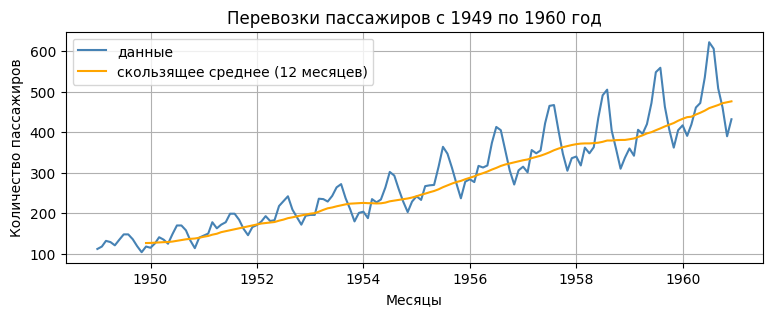

In [5]:
fig,ax = plt.subplots(figsize = (9,3))
ax.plot(df['#Passengers'], label = 'данные', color = 'steelblue')
ax.plot(df['#Passengers'].rolling(window=12).mean(), label = 'скользящее среднее (12 месяцев)', color = 'orange')
ax.set_xlabel('Месяцы', )
ax.set_ylabel('Количество пассажиров',)
ax.set_title('Перевозки пассажиров с 1949 по 1960 год', )
ax.legend(title = '', loc = 'upper left', )
ax.grid()

__оценка автокорреляции__

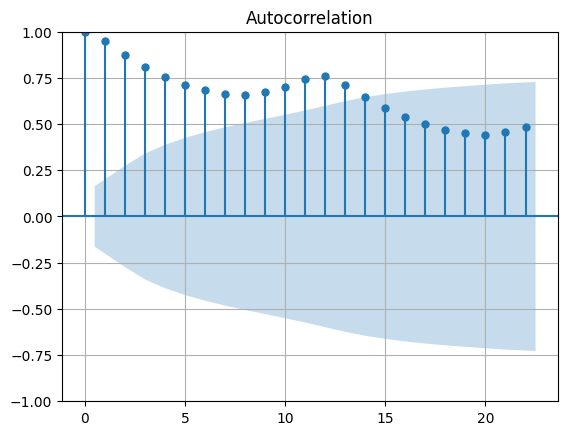

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['#Passengers'])
plt.grid()
plt.show()

__2. стабилизируем дисперсию (Бокс-Кокс)__

In [7]:
from scipy.special import boxcox

df['bcx'] = boxcox( df['#Passengers'],0 )

# from scipy.special import inv_boxcox
# df['bcx_inv'] = inv_boxcox(df['bcx'],0)

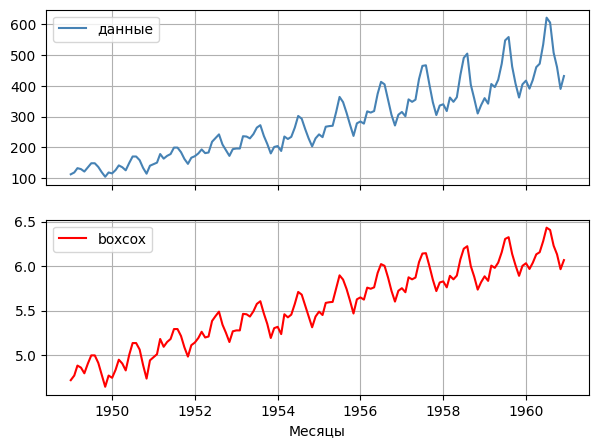

In [8]:
fig,ax = plt.subplots(2,1, figsize = (7,5),sharex=True)
ax[0].plot(df['#Passengers'], label = 'данные', color = 'steelblue')
ax[0].legend(title = '', loc = 'upper left', )
ax[0].grid()

ax[1].plot(df['bcx'], label = 'boxcox', color = 'red')
ax[1].legend(title = '', loc = 'upper left', )
ax[1].set_xlabel('Месяцы', )
ax[1].grid()

# модель

In [9]:
df.index = pd.DatetimeIndex(df.index.values, freq=df.index.inferred_freq)

# разобьём данные на обучающую и тестовую выборки

# обучающая выборка будет включать данные до декабря 1959 года включительно
train = df[:'1959-12']

# тестовая выборка начнется с января 1960 года (по сути, один год)
test = df['1960-01':]

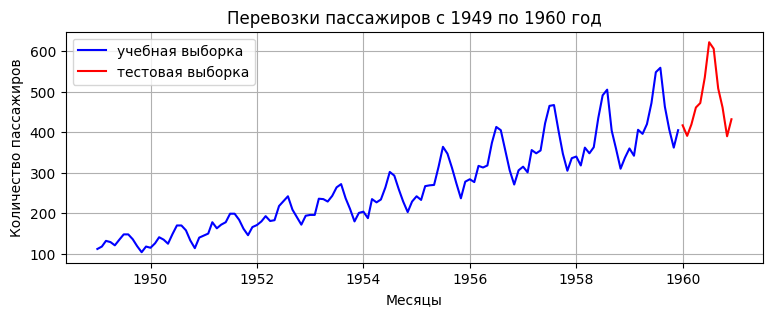

In [10]:
fig,ax = plt.subplots(figsize = (9,3))
ax.plot(train['#Passengers'], color = 'blue',label='учебная выборка')
ax.plot(test['#Passengers'], color = 'red',label='тестовая выборка')
ax.set_xlabel('Месяцы', )
ax.set_ylabel('Количество пассажиров',)
ax.set_title('Перевозки пассажиров с 1949 по 1960 год', )
ax.legend(title = '', loc = 'upper left', )
ax.grid()

In [14]:
# train

In [15]:
# !pip install pmdarima

In [16]:
# импортируем функцию для автоматического подбора параметров модели ARIMA
from pmdarima import auto_arima

# настроим поиск параметров на обучающей выборке
model = auto_arima(
        train['bcx'], 
        start_p=1, 
        start_q=1,
        max_p=3, 
        max_q=3, 
        m=12, 
        start_P=0,
        seasonal=True,
        d=None, 
        D=1, 
        trace=True, 
        error_action ='ignore', 
        suppress_warnings = True,  
        stepwise = True
    )           

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=-447.280, Time=0.97 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-317.949, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-433.027, Time=0.40 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-383.189, Time=0.29 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-134.983, Time=0.01 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=-416.167, Time=0.14 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=-444.966, Time=0.64 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=-445.305, Time=1.13 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=-439.764, Time=0.58 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=-442.847, Time=0.45 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=-446.292, Time=0.48 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-445.571, Time=0.65 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-327.548, Time=0.18 sec
 ARIMA(0,0,2)(0,1,1)[12]

In [19]:
# мы можем посмотреть результат с помощью метода summary()
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  132
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 229.026
Date:                              Wed, 24 Apr 2024   AIC                           -448.052
Time:                                      14:18:30   BIC                           -434.114
Sample:                                  01-01-1949   HQIC                          -442.392
                                       - 12-01-1959                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0194      0.009      2.164      0.030       0.002       0.037
ar.L1          0.59

# тестируем

In [41]:
from scipy.special import inv_boxcox

n_periods = len(test) # прогноз в месяцах
predicted =  inv_boxcox( model.predict( n_periods=n_periods),0 )

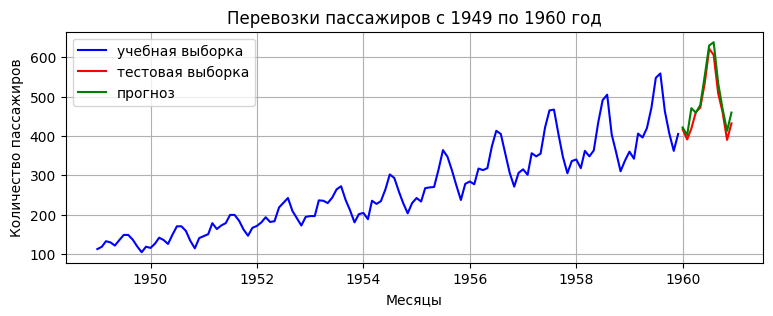

In [42]:
fig,ax = plt.subplots(figsize = (9,3))
ax.plot(train['#Passengers'], color = 'blue',label='учебная выборка')
ax.plot(test['#Passengers'], color = 'red',label='тестовая выборка')
ax.plot(predicted, color = 'green',  label='прогноз')

ax.set_xlabel('Месяцы', )
ax.set_ylabel('Количество пассажиров',)
ax.set_title('Перевозки пассажиров с 1949 по 1960 год', )
ax.legend(title = '', loc = 'upper left', )
ax.grid()

---

In [43]:
# построим прогноз на три года вперед
predicted = inv_boxcox( model.predict(n_periods=12*3), 0 )

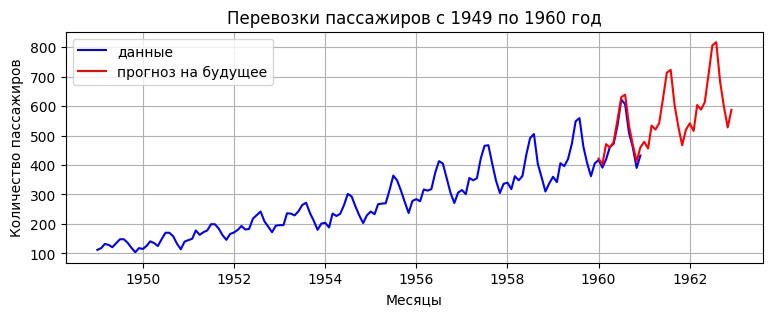

In [44]:
fig,ax = plt.subplots(figsize = (9,3))
ax.plot(df['#Passengers'], color = 'blue',label='данные')
ax.plot(predicted, color = 'red',label='прогноз на будущее')
ax.set_xlabel('Месяцы', )
ax.set_ylabel('Количество пассажиров',)
ax.set_title('Перевозки пассажиров с 1949 по 1960 год', )
ax.legend(title = '', loc = 'upper left', )
ax.grid()